In [112]:
#Import suppporting libraries
import tarfile
import urllib.request as urllib2
import os
from os import listdir
from os.path import isfile, join
import re
#Import deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, models
import torchvision.models as models
#Import data analytics libraries
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
#Import image visualization libraries
from PIL import *
from PIL import ImageFile
from PIL import Image
#System settings
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ['WANDB_CONSOLE'] = 'off'
#Coloring for print outputs
class color:
   RED = '\033[91m'
   BOLD = '\033[1m'
   END = '\033[0m'

In [148]:
df = pd.DataFrame(np.zeros((100,10)))

When dealing with image classification, people often start by classifying one or more categories within a class. For example, if you want to classify cars, you could make the distinction of whether it is a convertible or not. This would be an example of binary classification. A more complex task could be to distinguish between several categories. Is it an Audi, a BMW, a Mercedes or a Ford? There is more than one category within the car brand. What if we want to combine both examples? We could classify multiple features at once for each image showing a vehicle, e.g. the brand, the vehicle type, and the year of manufacture. One way would be to train three independent classifiers, but it is also possible to integrate everything into one model. We will do this together with the Stanford Car Dataset. Here we go:

In [113]:
if False:
    def getting_data(url,path):
      data = urllib2.urlopen(url)
      tar_package = tarfile.open(fileobj=data, mode='r:gz')
      tar_package.extractall(path)
      tar_package.close()
      return print("Data extracted and saved.")

    getting_data("http://ai.stanford.edu/~jkrause/car196/car_ims.tgz","/content/carimages")

    def getting_metadata(url,filename):
      '''
      Downloading a metadata file from a specific url and save it to the disc.
      '''
      labels = urllib2.urlopen(url)
      file = open(filename, 'wb')
      file.write(labels.read())
      file.close()
      return print("Metadata downloaded and saved.")

    getting_metadata("http://ai.stanford.edu/~jkrause/car196/cars_annos.mat","car_metadata.mat")

First, we created two functions to a) download and extract the images themselves and b) store the corresponding metadata (containing information about the brand and model). In a next step, we create a class that merges both information and extracts a total of three relevant features:
1. All brands in the dataset with more than 1000 images. We put all other brands into the category "Other".
2. We distinguish between different types of vehicles: Convertible, Coupe, SUV, Van.  All models without reference to the vehicle type, we summarize to the category "Other".
3. We divide the carpool into two cohorts: All cars released in 2009 and earlier and all cars released in 2010 and later.

So we have three targets with different classes, each of which we want to predict all at the same time. We can extract all the needed information from the metadata.

In [114]:
if True:
    class MetaParsing():
      '''
      Class for parsing image and meta-data for the Stanford car dataset to create a custom dataset.
      path: The filepah to the metadata in .mat format.
      *args: Accepts dictionaries with self-created labels which will be extracted from the metadata (e.g. {0: 'Audi', 1: 'BMW', 3: 'Other').
      year: Can be defined to create two classes (<=year and later).
      '''
      def __init__(self,path,*args,year=None):
        self.mat = scipy.io.loadmat(path)
        self.year = year
        self.args = args
        self.annotations = np.transpose(self.mat['annotations'])
        #Extracting the file name for each sample
        self.file_names = [annotation[0][0][0].split("/")[-1] for annotation in self.annotations]
        #Extracting the index of the label for each sample
        self.label_indices = [annotation[0][5][0][0] for annotation in self.annotations]
        #Extracting the car names as strings
        self.car_names = [x[0] for x in self.mat['class_names'][0]]
        #Create a list with car names instead of label indices for each sample
        self.translated_car_names = [self.car_names[x-1] for x in self.label_indices]
      def brand_types(self,base_dict, x):
        y = list(base_dict.keys())[-1]
        for k,v in base_dict.items():
          if v in x: y=k
        return y
      def parsing(self):
        result = []
        for arg in self.args:
          temp_list = [self.brand_types(arg,x) for x in self.translated_car_names]
          result.append(temp_list)
        if self.year != None:
          years_list = [0 if int(x.split(" ")[-1]) <= self.year else 1 for x in self.translated_car_names]
          result.append(years_list)
        brands = [x.split(" ")[0] for x in self.translated_car_names]
        return result, self.file_names, self.translated_car_names

As described in the docstrings of the class, we can pass dictionaries that contain the characteristics for our class:

In [115]:
if True:
    brand_dict = {0: 'Audi', 1: 'BMW', 2: 'Chevrolet', 3: 'Dodge', 4: 'Ford', 5: 'Other'}
    vehicle_types_dict = {0: 'Convertible', 1: 'Coupe', 2: 'SUV', 3: 'Van', 4: 'Other'}

    results, file_names, translated_car_names = MetaParsing("content/car_metadata.mat",brand_dict,vehicle_types_dict,year=2009).parsing()
    len(results)

As expected, we get a list containing three lists of numeric features for our three classes (brand, type, year). These are our training labels. We can use the dictionaries to reassign them later.

In [116]:
if True:
    def count_classes(base_dict, base_list):
      for i in range(len(list(base_dict.keys()))):
        print("{}: {}".format(base_dict[i], str(base_list.count(i))))

    count_classes(brand_dict,results[0])
    count_classes(vehicle_types_dict,results[1])

Audi: 1169
BMW: 1055
Chevrolet: 1799
Dodge: 1253
Ford: 1035
Other: 9874
Convertible: 1907
Coupe: 2143
SUV: 2855
Van: 832
Other: 8448


At first glance, we have enough cases for each class. We do have skewed distributions, but we could mitigate that with weighting (https://discuss.pytorch.org/t/passing-the-weights-to-crossentropyloss-correctly/14731/10). We leave the classes as they are and create a dictionary for our custom dataset. We assign the corresponding tainings labels to each filename:

In [117]:
if True:
    translation_dict = dict(zip(file_names,list(zip(results[0],results[1],results[2]))))

Next we will create our custom dataset. For a deeper introduction you can have a look at this article of mine. Basically, there is nothing special yet. The only difference is that we load three tainingslabels for each sample instead of one, and pass all three into our training loop:

In [118]:
if True:
    class CarDataset(Dataset):
      def __init__(self,car_path,transform,translation_dict):
        self.path = car_path
        self.folder = [x for x in listdir(car_path)]
        self.transform = transform
        self.translation_dict = translation_dict

      def __len__(self):
        return len(self.folder)

      def __getitem__(self,idx):
        img_loc = os.path.join(self.path, self.folder[idx])
        image = Image.open(img_loc).convert('RGB')
        single_img = self.transform(image)

        label1 = translation_dict[self.folder[idx]][0]
        label2 = translation_dict[self.folder[idx]][1]
        label3 = translation_dict[self.folder[idx]][2]

        sample = {'image':single_img, 'labels': {'brand':label1, 'vehicle_type':label2, 'epoch':label3}, 'path':img_loc}
        return sample   

    #Pre-processing transformations
    data_transforms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
        ])

    #Getting the data
    cardata = CarDataset("content/carimages/car_ims", transform=data_transforms,translation_dict=translation_dict)

    #Split the data in training and testing
    train_len = int(cardata.__len__()*0.8)
    test_len = int(cardata.__len__()*0.2)
    train_set, val_set = torch.utils.data.random_split(cardata, [train_len, test_len],
                                                      generator=torch.Generator().manual_seed(42))

    #Create the dataloader for each dataset
    train_loader = DataLoader(train_set, batch_size=16, shuffle=False, 
                                    num_workers=4, drop_last=True)
    test_loader = DataLoader(val_set, batch_size=16, shuffle=False, 
                                   num_workers=4, drop_last=True)

In [119]:
from tqdm import tqdm

In [120]:
if False:
    paths = []
    train_or_test = []
    brand = []
    vehicle_type = []
    epoch = []

    for batch in tqdm(train_loader):
        paths.extend(batch["path"])
        train_or_test.extend(list(np.zeros(len(batch["path"]), dtype=int)))

        brand.extend(batch["labels"]["brand"])
        vehicle_type.extend(batch["labels"]["vehicle_type"])
        epoch.extend(batch["labels"]["epoch"])

    for batch in tqdm(test_loader):
        paths.extend(batch["path"])
        train_or_test.extend(list(np.ones(len(batch["path"]), dtype=int)))

        brand.extend(batch["labels"]["brand"])
        vehicle_type.extend(batch["labels"]["vehicle_type"])
        epoch.extend(batch["labels"]["epoch"])
    
    brand = [b.item() for b in brand]
    vehicle_type = [t.item() for t in vehicle_type]
    epoch = [e.item() for e in epoch]
    df = pd.DataFrame()
    df["path"] = [l.replace("content/carimages/car_ims/", "images/") for l in list(paths)]
    df["train_or_test"] = list(train_or_test)
    df["brand"] = list(brand)
    df["vehicle_type"] = list(vehicle_type)
    df["epoch"] = list(epoch)
    df.to_csv("stanford_cars/labels.csv")

In [121]:
class MultiLabelDataset(Dataset):
    def __init__(self, csv, root_dir, col_img_pth = "filename", cols_features = [], subset = "train",
                 train_val_test = [.8,.2,.0], random_seed = 42, transform = None, shuffle = False, col_train_or_test=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if type(csv) == type(str):
            self.csv = pd.read_csv(csv)
        else:
            self.csv = csv
        if shuffle:
            self.csv.sample(frac=1, random_state = random_seed)
            
        self.root_dir = root_dir
        self.imgs = [os.path.join(root_dir, img) for img in list(self.csv[col_img_pth])]

        self.features = [list(self.csv[c]>.5) for c in cols_features]
            
        if not col_train_or_test:
            train_val_test = [int(len(self.imgs) * train_val_test[0]),
                              int(len(self.imgs) * train_val_test[1]),
                              int(len(self.imgs) * train_val_test[2])]
            if subset == "train":
                self.imgs = self.imgs[:train_val_test[0]]
            elif subset == "val":
                self.imgs = self.imgs[train_val_test[0]:train_val_test[0]+train_val_test[1]]
            elif subset == "test":
                self.imgs = self.imgs[train_val_test[0]+train_val_test[1]:]
            elif subset == "all":
                self.imgs = self.imgs[:]
            else:
                assert False

            self.features = np.array(self.features, dtype = bool).T
            if subset == "train":
                self.features = self.features[:train_val_test[0]]
            elif subset == "val":
                self.features = self.features[train_val_test[0]:train_val_test[0]+train_val_test[1]]
            elif subset == "test":
                self.features = self.features[train_val_test[0]+train_val_test[1]:]
            elif subset == "all":
                self.features = self.features[:]
            else:
                assert False
        else:
            assert col_train_or_test in self.csv.keys()
            if subset == "train":
                self.csv = self.csv.loc[self.csv[col_train_or_test].values == 0]
            elif subset == "test" or subset == "val":
                self.csv = self.csv.loc[self.csv[col_train_or_test].values == 1]   
            self.imgs = [os.path.join(root_dir, img) for img in list(self.csv[col_img_pth])]
            self.features = [list(self.csv[c]>.5) for c in cols_features]
            
        self.transform = transform
        self.cols_features =cols_features

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx]).convert('RGB')#torch.tensor(np.array(), dtype=np.float).permute(2,0,1).type(torch.float)
        if type(self.transform) != type(None):
            img = self.transform(img)
        #labels = torch.tensor(self.features[idx], dtype=torch.float)
        return {"image":img, "labels": {k:self.csv[k].values[idx] for k in self.cols_features}, "path":self.imgs[idx]}

#Pre-processing transformations
data_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

if True:
    csv = pd.read_csv("stanford_cars/labels.csv")
    root_dir = "stanford_cars"
    train_set1 = MultiLabelDataset(csv, root_dir, col_img_pth = "path", cols_features = ["brand", "vehicle_type", "epoch"], subset = "train",
                                  transform = data_transforms, shuffle = False, col_train_or_test = "train_or_test")
    val_set1 = MultiLabelDataset(csv, root_dir, col_img_pth = "path", cols_features = ["brand", "vehicle_type", "epoch"], subset = "val",
                                  transform = data_transforms, shuffle = False, col_train_or_test = "train_or_test")

    #Create the dataloader for each dataset
    train_loader1 = DataLoader(train_set1, batch_size=16, shuffle=False, 
                                    num_workers=4, drop_last=True)
    test_loader1 = DataLoader(val_set1, batch_size=16, shuffle=False, 
                                   num_workers=4, drop_last=True)

We can load a sample with the dataloader:

In [122]:
if False:
    def plot_my_data(mystring,n, data):
        """"""
        for i in range(n):
            print("hallo")

In [123]:
sample = next(iter(train_loader1))

In [124]:
print("Keys in our sample batch: {}".format(sample.keys()))
print("Size for the images in our sample batch: {}".format(sample['image'].shape))
print("Size for the target in our sample batch: {}".format(sample['labels']['brand'].shape))
print("Targets for each batch in our sample: {}".format(sample['labels']['brand']))

Keys in our sample batch: dict_keys(['image', 'labels', 'path'])
Size for the images in our sample batch: torch.Size([16, 3, 224, 224])
Size for the target in our sample batch: torch.Size([16])
Targets for each batch in our sample: tensor([5, 5, 5, 4, 2, 5, 5, 5, 5, 5, 2, 0, 0, 1, 5, 5])


Our custom dataset and the dataloader work as intended. We get one dictionary per batch with the images and 3 target labels. With this we have the prerequisites for our multilabel classifier.

In [125]:
resnet = models.resnet34(pretrained=True)
list(resnet.children())[-3:]

/home/gerstenberger/anaconda3/envs/optical_flow/lib/python3.9/site-packages/torchvision/models/_utils.py:207: UserWarning: The parameter 'pretrained' is deprecated, please use 'weights' instead.
  warnings.warn(
/home/gerstenberger/anaconda3/envs/optical_flow/lib/python3.9/site-packages/torchvision/models/_utils.py:220: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

First, we load a pre-trained ResNet34 and display the last 3 children elements. First comes a sequential block, then a pooling operation and finally a linear layer. This gets 512 features as input and gives 1000 as output. We want to remove this last layer and replace it with new layers. We already know that we have 512 in-features each and need a) 6 out-featues for the brands, b) 5 out-features for the vehicle types and c) 2 out-features for the epochs. We can remove the last layer by putting all children elements into a list and removing the last element:

In [126]:
#model_wo_fc = nn.Sequential(*(list(resnet.children())[:-1]))

We can process an output with our resnet without a classifier head and look at the respective tensor shapes:

In [127]:
#output_sample = model_wo_fc(sample['image'])
#print(output_sample.shape)
#print(torch.flatten(output_sample, 1).shape)

As a result we get a tensor with the format [16,512,1,1]. We have 16 samples in our batch and 512 features per image. The 3rd and 4th dimension has size 1 and can be smoothed by torch.flatten. We can now pass this output to our new classifier layers:

In [128]:
if False:
    output_sample_flatten = torch.flatten(output_sample, 1)
    brand = nn.Sequential(
                nn.Dropout(p=0.2),
                nn.Linear(in_features=512, out_features=6)
            )
    brand(output_sample_flatten).shape

This is exactly what we wanted to have. We get 6 logits per sample in our batch. We can now process these as usual using a loss function in our training loop. Now we add the other two classifier layers and put everything together in a custom model:

In [129]:
class MultilabelClassifier(nn.Module):
    def __init__(self, feature_categories = [], classes_of_categories = []):
        super().__init__()
        self.backbone = models.resnet34(pretrained=True)
        self.encoder = nn.Sequential(*(list(self.backbone.children())[:-1]))
        
        self.classification_heads = []
        self.feature_categories = feature_categories
        
        for n in classes_of_categories:
            head = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(in_features=512, out_features=n)).to(device)
            self.classification_heads.append(head)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        return {name:head(x) for name, head in zip(self.feature_categories, self.classification_heads)}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([224, 224, 3])


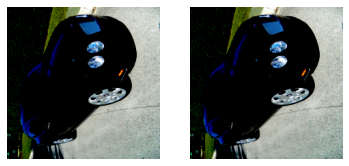

In [131]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(next(iter(train_loader))["image"][0].permute(2,1,0))
ax[1].imshow(next(iter(train_loader1))["image"][0].permute(2,1,0))
for a in ax:
    a.axis("off")
    
print(next(iter(train_loader))["image"][0].permute(2,1,0).shape)

We create a flexible training routine that takes into account all outputs of our model. Therefore, it does not matter whether we have 2, 3 or, for example, 5 classifier heads. We simply use the conventional loss function for multiclassification tasks. We calculate the CrossEntropyLoss for each Head and sum the Losses. This way we can optimize the weights with a single optimizer step for all three heads:

In [132]:
from tqdm import tqdm

In [133]:
def criterion(loss_func,outputs,batch):
  losses = 0
  for i, key in enumerate(outputs):
    losses += loss_func(outputs[key], batch['labels'][f'{key}'].to(device))
  return losses

def training(model,device,lr_rate,epochs,train_loader):
  num_epochs = epochs
  losses = []
  checkpoint_losses = []

  optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
  n_total_steps = len(train_loader)

  loss_func = nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
     for i, pictures in tqdm(enumerate(train_loader)):
        images = pictures['image'].to(device)
        pictures = pictures

        outputs = model(images)

        loss = criterion(loss_func,outputs, pictures)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % (int(n_total_steps/1)) == 0:
            checkpoint_loss = torch.tensor(losses).mean().item()
            checkpoint_losses.append(checkpoint_loss)
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {checkpoint_loss:.4f}')
  return checkpoint_losses


We also write the validation routine so that we can pass a flexible number of categories to be classified. We calculate both the total performance per class and the performance per category:

In [134]:
def validation(model, dataloader, *args):

  all_predictions = torch.tensor([]).to(device)
  all_true_labels = torch.tensor([]).to(device)

  with torch.no_grad():
    n_correct = []
    n_class_correct = []
    n_class_samples = []
    n_samples = 0

    for arg in args:
      n_correct.append(len(arg))
      n_class_correct.append([0 for i in range(len(arg))])
      n_class_samples.append([0 for i in range(len(arg))])

    for pictures in dataloader:
      images = pictures['image'].to(device)
      outputs = model(images)
      labels = [pictures['labels'][picture].to(device) for picture in pictures['labels']]

      for i,out in enumerate(outputs):
        _, predicted = torch.max(outputs[out],1)
        n_correct[i] += (predicted == labels[i]).sum().item()

        if i == 0:
          n_samples += labels[i].size(0)

        for k in range(16):
          label = labels[i][k]
          pred = predicted[k]
          if (label == pred):
              n_class_correct[i][label] += 1
          n_class_samples[i][label] += 1
          
  return n_correct,n_samples,n_class_correct,n_class_samples

def class_acc(n_correct,n_samples,n_class_correct,n_class_samples,class_list):
    for i in range(len(class_list)):
      print("-------------------------------------------------")
      acc = 100.0 * n_correct[i] / n_samples
      print(color.BOLD + color.RED + f'Overall class performance: {round(acc,1)} %' + color.END)
      for k in range(len(class_list[i])):
          acc = 100.0 * n_class_correct[i][k] / n_class_samples[i][k]
          print(f'Accuracy of {class_list[i][k]}: {round(acc,1)} %')
    print("-------------------------------------------------")

classes_brand = list(brand_dict.values())
classes_vehicle_type = list(vehicle_types_dict.values())
classes_epoch = ['2009 and earlier','2010 and later']
class_list = [classes_brand,classes_vehicle_type,classes_epoch]

In [135]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultilabelClassifier(feature_categories = ["brand", "vehicle_type", "epoch"], classes_of_categories =[6,5,2]).to(device)
checkpoint_losses = training(model,device,0.0001,10,train_loader1)

809it [00:52, 15.49it/s]

Epoch [1/10], Step [809/809], Loss: 2.0610



809it [00:45, 17.80it/s]

Epoch [2/10], Step [809/809], Loss: 1.4821



809it [00:54, 14.80it/s]

Epoch [3/10], Step [809/809], Loss: 1.1415



809it [00:53, 15.10it/s]

Epoch [4/10], Step [809/809], Loss: 0.9329



809it [00:55, 14.70it/s]

Epoch [5/10], Step [809/809], Loss: 0.7917



809it [00:54, 14.90it/s]

Epoch [6/10], Step [809/809], Loss: 0.6893



809it [00:56, 14.38it/s]

Epoch [7/10], Step [809/809], Loss: 0.6125



809it [00:53, 15.00it/s]

Epoch [8/10], Step [809/809], Loss: 0.5544



809it [00:56, 14.45it/s]

Epoch [9/10], Step [809/809], Loss: 0.5073



809it [00:53, 15.02it/s]

Epoch [10/10], Step [809/809], Loss: 0.4680


In [136]:
n_correct,n_samples,n_class_correct,n_class_samples = validation(model,test_loader1,classes_brand,classes_vehicle_type,classes_epoch)
class_acc(n_correct,n_samples,n_class_correct,n_class_samples,class_list)

-------------------------------------------------
Overall class performance: 89.5 %
Accuracy of Audi: 87.6 %
Accuracy of BMW: 90.0 %
Accuracy of Chevrolet: 77.0 %
Accuracy of Dodge: 89.9 %
Accuracy of Ford: 78.2 %
Accuracy of Other: 93.0 %
-------------------------------------------------
Overall class performance: 87.4 %
Accuracy of Convertible: 78.7 %
Accuracy of Coupe: 81.6 %
Accuracy of SUV: 91.6 %
Accuracy of Van: 76.4 %
Accuracy of Other: 90.1 %
-------------------------------------------------
Overall class performance: 88.6 %
Accuracy of 2009 and earlier: 83.6 %
Accuracy of 2010 and later: 90.8 %
-------------------------------------------------


With about 90% accuracy per class, we were able to make good predictions. We saw that we can classify multiple classes with one model without needing multiple models or runs. In our example, we used PyTorch and saw that we can quickly create a custom training routine with a custom dataset and a custom model. Furthermore, we took advantage of transfer learning to get good results quickly despite the complexity of the task. In the real world, there are many such application areas. Imagine you run a used car platform and want to extract suggestions for individual vehicle features directly from the images. We are not that far away from that in our example. There is another form of multilabel classification. Think of image tags in social networks, for example. Here, one has also given certain class, but not every image is forcibly assigned to every class. We will address this issue in the next chapter. Thanks for reading!

In [39]:
class_list

[['Audi', 'BMW', 'Chevrolet', 'Dodge', 'Ford', 'Other'],
 ['Convertible', 'Coupe', 'SUV', 'Van', 'Other'],
 ['2009 and earlier', '2010 and later']]